In [5]:
!pip install wordcloud textblob pandas matplotlib seaborn nltk
!pip install --upgrade pip
!pip install --upgrade scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [6]:
# Load dataset into Pandas DataFrame
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)

# Rename columns for easier use
df.columns = ["sentiment", "id", "date", "query", "user", "text"]

# Drop unnecessary columns
df = df[["sentiment", "text"]]

# Convert sentiment labels (0 -> negative, 4 -> positive)
df["sentiment"] = df["sentiment"].replace({0: "negative", 4: "positive"})

# Display dataset info
print(df.head())


  sentiment                                               text
0  negative  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1  negative  is upset that he can't update his Facebook by ...
2  negative  @Kenichan I dived many times for the ball. Man...
3  negative    my whole body feels itchy and like its on fire 
4  negative  @nationwideclass no, it's not behaving at all....


/tmp/ipython-input-6-2673673104.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["sentiment"].replace({0: "negative", 4: "positive"})


In [7]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"@\w+|\#", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters and punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuations
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply cleaning function
df["clean_text"] = df["text"].apply(clean_text)

# Show cleaned text
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  sentiment                                               text  \
0  negative  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  negative  is upset that he can't update his Facebook by ...   
2  negative  @Kenichan I dived many times for the ball. Man...   
3  negative    my whole body feels itchy and like its on fire    
4  negative  @nationwideclass no, it's not behaving at all....   

                                          clean_text  
0      thats bummer shoulda got david carr third day  
1  upset cant update facebook texting might cry r...  
2  dived many times ball managed save 50 rest go ...  
3                   whole body feels itchy like fire  
4                           behaving im mad cant see  


/tmp/ipython-input-8-1355598.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["sentiment"], palette="coolwarm")


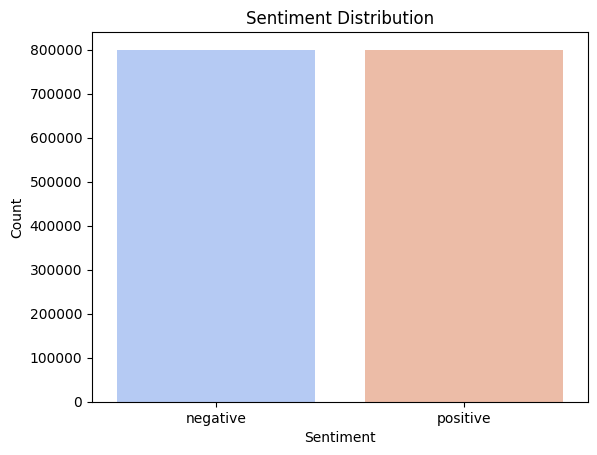

In [8]:
sns.countplot(x=df["sentiment"], palette="coolwarm")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


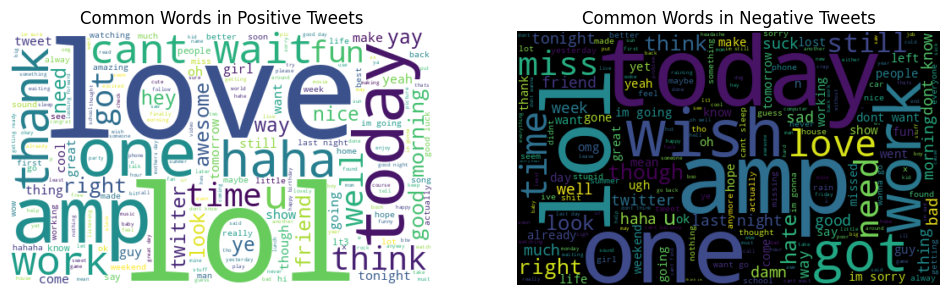

In [9]:
positive_text = " ".join(df[df["sentiment"] == "positive"]["clean_text"])
negative_text = " ".join(df[df["sentiment"] == "negative"]["clean_text"])

plt.figure(figsize=(12, 5))

# Positive Sentiment
plt.subplot(1, 2, 1)
plt.title("Common Words in Positive Tweets")
wordcloud = WordCloud(background_color="white", width=500, height=300).generate(positive_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Negative Sentiment
plt.subplot(1, 2, 2)
plt.title("Common Words in Negative Tweets")
wordcloud = WordCloud(background_color="black", width=500, height=300).generate(negative_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()


In [10]:
# Convert text into numerical data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

# Encode labels
y = df["sentiment"].map({"positive": 1, "negative": 0})

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred))


Accuracy: 77.38%
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [11]:
def predict_sentiment(text):
    cleaned_text = clean_text(text)  # Clean input text
    vectorized_text = vectorizer.transform([cleaned_text])  # Convert to numerical data
    prediction = model.predict(vectorized_text)[0]  # Get prediction
    sentiment_label = "Positive 😊" if prediction == 1 else "Negative 😡"
    return sentiment_label

# Example Prediction
tweet = "I love this new phone! It's amazing. 📱"
print(f"Tweet: {tweet}")
print(f"Predicted Sentiment: {predict_sentiment(tweet)}")


Tweet: I love this new phone! It's amazing. 📱
Predicted Sentiment: Positive 😊


In [12]:
!pip install tweepy

import tweepy